In [2]:
from matplotlib.image import imread
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import pywt
import os
from PIL import Image
from skimage import color
from sklearn import svm
import pandas as pd

In [3]:
HIST_FOLDER = r'D:\GABY\UPH\TA2\Code2\face-detection-result-clean-resized-gray-hist'
DWT_WITH_DCT_FOLDER = r'D:\GABY\UPH\TA2\Code2\face-detection-result-clean-resized-gray-hist-dwtwithdct'
TEST_DWT_WITH_DCT_FOLDER = r'D:\GABY\UPH\TA2\Code2\test-face-detection-result-clean-resized-gray-hist-dwtwithdct'
CSV_FOLDER = r'D:\GABY\UPH\TA2\Code2\training-data.csv'
TEST_FOLDER = r'D:\GABY\UPH\TA2\Code2\test-face-detection-result-clean-resized-gray-hist'
TEST_CSV = r'D:\GABY\UPH\TA2\Code2\testing-data.csv'

In [4]:
#find number of images in file
list = os.listdir(HIST_FOLDER) # dir is your directory path
number_files = len(list)

## Training Phase

### Discrete Wavelet Transform

In [9]:
#Wavelet Compression
n=2
w = 'haar'

#features array for SVM
x1 = []

for iteration in range(number_files):
    i = iteration+1
    img = Image.open(f'{HIST_FOLDER}/{str(i)}.jpg')
    coeffs = pywt.wavedec2(img, wavelet = w, level = n) 
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs) #arrange coeffs into single array
    
    features = coeff_arr[coeff_slices[0]]
    plt.imsave(f'{DWT_WITH_DCT_FOLDER}/{str(i)}.jpg', features)

    x1.append(features)    

### Discrete Cosine Transform

In [79]:
from scipy.fft import dctn, idctn
import cv2

In [149]:
list = os.listdir(DWT_WITH_DCT_FOLDER) # dir is your directory path
number_files = len(list)

In [150]:
dct_coeffs =[]

In [151]:
for i in range(number_files):
    img = imread(f'{DWT_WITH_DCT_FOLDER}/{str(i+1)}.jpg')
    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(grayimg)
    coeff = dctn(equ , norm ='ortho')
    dct_coeffs.append(coeff)

In [152]:
dct_coeffs[0]

array([[ 3.55307264e+04, -1.10467544e+03,  2.33867327e+03, ...,
        -5.67281685e+00, -3.93516450e+00,  8.49691528e+00],
       [ 3.39302431e+02, -4.41834155e+02, -1.05114683e+04, ...,
        -9.44303168e-01,  8.47502674e+00, -1.69089507e+00],
       [ 1.46579748e+03,  2.08534140e+02,  2.66105791e+02, ...,
         3.15892056e+00, -8.49138550e+00, -7.79898166e+00],
       ...,
       [-1.04857524e+01,  1.95625425e+01,  7.64251511e+00, ...,
        -2.23102150e+00,  3.02501739e+00,  5.29610206e-01],
       [-1.65875744e+01,  3.51485734e+01,  8.80917794e+00, ...,
         8.41625397e-01, -1.38566736e+00,  4.07407547e+00],
       [ 7.59361746e+00,  1.07669604e+01, -5.19115715e+00, ...,
         4.71177986e+00, -9.22727930e-01, -4.47031955e-01]])

find minimum number of coefficients (n)

In [153]:
coeffs_min = len(dct_coeffs[0])*len(dct_coeffs[0][0])
ind_coeffs_min = 0

In [154]:
for i in range(len(dct_coeffs)):
    if(len(dct_coeffs[i])*len(dct_coeffs[i][0])<coeffs_min):
        coeffs_min = len(dct_coeffs[i])*len(dct_coeffs[i][0])
        ind_coeffs_min = i

In [155]:
coeffs_min

75884

In [156]:
coeffs_picked = 10000

for all images, choose n coefficients for svm input

In [157]:
new_coeffs = []
for i in range(number_files):
    whole = []
    for j in range(20):
        row = []
        for k in range(20):
            row.append(dct_coeffs[i][j][k])
        whole.append(row)
    new_coeffs.append(whole)

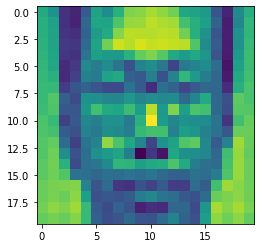

In [158]:
plt.imshow(idctn(new_coeffs[0], norm = 'ortho'))

Flatten coefficients

In [159]:
flat_coeff = []

In [160]:
for n in range(number_files):
    height = len(new_coeffs[n])
    width = len(new_coeffs[n][0])
    row = []
    for k in range(width+height-1):
        for j in range(k+1):
            i = k-j
            if i<height and j<width:
                if len(row) < coeffs_picked:
                    row.append(new_coeffs[n][i][j])
    flat_coeff.append(row)

In [161]:
new_coeffs_pd = pd.DataFrame(flat_coeff)
new_coeffs_pd.to_csv('dct_coeffs_flat_try2.csv')

In [162]:
new_coeffs_pd

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,35530.726354,339.302431,-1104.675443,1465.797479,-441.834155,2338.673272,2533.026742,208.534140,-10511.468255,589.131927,...,-106.276322,-444.132115,-193.006239,-116.850212,200.585009,-57.582368,35.974862,160.617830,240.569597,-112.904542
1,35560.801501,-73.405088,-734.855326,1880.762241,-536.093045,2256.078619,1047.333448,-31.772286,-10524.564399,1700.830935,...,-179.492683,125.810356,30.795235,165.505108,388.559361,27.958032,-25.265712,79.725738,-107.614407,-157.151547
2,35508.809777,347.132598,-1912.235292,1513.139065,227.612058,797.420277,3145.428522,79.897299,-10388.146569,-265.857281,...,-336.317299,-26.753344,-396.634828,-21.984749,32.911497,105.394842,-31.220666,206.339047,-55.155792,-16.463466
3,35515.625428,1679.644474,-1267.463421,2112.235578,-2210.929963,-2800.308896,-1033.975768,-123.009030,-9858.324506,1106.828716,...,-79.521877,-341.493929,170.306757,-287.944455,296.485615,134.572092,514.712024,88.406415,44.720962,-124.632140
4,35542.627064,1714.834596,-7695.765531,-559.495868,-234.191803,-1405.037529,3955.562106,-926.961685,-8906.362495,-5583.995198,...,303.867566,66.651668,271.346594,40.476194,-17.418472,4.699538,-176.966339,-35.093843,-10.585242,238.784001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,35522.063072,-5185.606870,-7696.660437,262.741595,-2851.665708,5167.002572,-804.468824,-329.040059,-7214.510591,-2714.244165,...,-78.275738,-119.280384,5.856206,-146.377486,242.751873,18.115837,-205.586672,-55.971218,215.072276,-75.345302
212,35500.408892,-5543.702572,3966.989054,-2007.824151,1770.093611,2525.580814,671.081892,1428.250556,-7166.029043,5052.338099,...,-82.219633,494.834735,-271.107484,-145.884489,-30.630003,-221.243245,84.605254,-15.269027,-231.154835,-21.269819
213,35507.314124,-5646.581454,3954.296643,-2164.250523,1213.542475,4068.726359,601.936017,1924.625860,-7254.840330,4348.244638,...,-302.111927,318.829295,184.338780,389.627066,215.218934,-253.453512,69.290957,-25.877780,-280.701319,-126.231823
214,35493.409611,-4442.382612,4180.062691,-717.776212,1043.162974,4032.414284,1498.121176,1662.872255,-7737.803825,4856.049456,...,-104.075904,8.609871,160.625897,251.381699,114.783684,-260.362366,11.945250,-84.883975,-22.203485,84.466070


In [163]:
new_coeffs_pd.iloc[0].max()

35530.726353630525

In [164]:
norm_dct_coeffs = []

In [165]:
for i in range(number_files):
    min_data = new_coeffs_pd.iloc[i].min()
    max_data = new_coeffs_pd.iloc[i].max()
    row = []
    for j in range(400):
        temp = (new_coeffs_pd.iloc[i][j]-min_data)/(max_data-min_data)*100
        row.append(temp)
    norm_dct_coeffs.append(row)

### SVM

Train data

In [166]:
x = pd.DataFrame(norm_dct_coeffs)
y = pd.read_csv(CSV_FOLDER, header=None)

Validation data

In [167]:
from sklearn.model_selection import train_test_split

In [168]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

In [169]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
136,100.0,0.000000,2.989403,3.022481,22.282607,31.455727,16.574657,19.032750,12.229831,10.626906,...,19.560812,19.792461,19.476651,19.406069,19.849905,20.050022,20.023653,19.877076,20.046136,19.604806
123,100.0,28.895769,12.029919,0.000000,18.918748,0.249052,2.506681,16.362028,20.341461,18.065091,...,18.273672,17.715325,17.902512,17.771824,17.134869,18.006343,17.447834,17.305322,17.174393,17.573134
22,100.0,0.000000,26.223265,1.039103,10.843716,9.429635,19.146157,18.701321,8.309994,27.294455,...,16.548104,16.112169,15.760737,16.141102,16.737613,16.437354,16.469043,16.095614,16.501699,16.263864
80,100.0,16.831257,25.977331,1.924016,13.006336,5.313874,22.734085,18.114015,0.000000,31.721833,...,12.462328,12.494078,12.765727,12.928671,12.590123,12.650511,12.782672,12.814985,12.873406,12.360623
45,100.0,12.722292,25.693444,18.032594,17.080240,36.794907,20.975917,17.542208,0.000000,15.191558,...,15.815383,15.600454,15.947882,16.749045,15.601230,15.610916,15.722812,15.727040,15.560232,15.473122


build classifier with default parameter values

In [170]:
classifier = svm.SVC()
classifier.fit(x_train,y_train.values.ravel())

SVC()

In [171]:
result = classifier.predict(x_val)

In [172]:
result

array([ 4,  4,  8,  4,  4,  7,  4, 16,  1,  4,  1,  1,  1, 18,  7, 18, 17,
        3, 18, 18,  6,  1,  3, 16, 11, 11, 18,  3,  8,  4,  1,  4,  4, 18,
       16,  4,  4,  3,  8,  4,  4, 16, 11, 11], dtype=int64)

In [173]:
y_val.to_csv('dct_correct_try2.csv')

In [174]:
result_pd = pd.DataFrame(result)
result_pd.to_csv('dct_result1_try2.csv')
result_pd.tail()

,0
39,4
40,4
41,16
42,11
43,11


In [175]:
#checking for accuracy
cnt = 0
for i in range(len(y_val)):
    if(result[i]==y_val[0].values[i]):
        cnt = cnt+1
acc = cnt/len(y_val)
cnt

13

In [176]:
acc*100

29.545454545454547

Trying out different values of C and gamma

In [177]:
c_vals = np.arange(1,20)
g_vals = ['scale', 'auto']
len(g_vals)

2

In [178]:
right_guess = []
accuracies = []

In [179]:
for c_val in c_vals:
    row_guess = []
    row_acc = []
    for g_val in g_vals:
        classifier = svm.SVC(C = c_val, gamma = g_val)
        classifier.fit(x_train,y_train.values.ravel())
        result = classifier.predict(x_val)
        cnt = 0
        for i in range(len(y_val)):
            if(result[i]==y_val[0].values[i]):
                cnt = cnt+1
        acc = cnt/len(y_val)
        row_guess.append(cnt)
        row_acc.append(acc*100)
    right_guess.append(row_guess)
    accuracies.append(row_acc)

In [180]:
right_guess = np.array(right_guess)

In [181]:
right_guess_df = pd.DataFrame(right_guess)
right_guess_df.columns = g_vals
right_guess_df.index = c_vals
right_guess_df

,scale,auto
1,13,13
2,22,16
3,25,16
4,28,16
5,32,16
6,36,16
7,35,16
8,36,16
9,37,16
10,37,16


In [182]:
top = right_guess_df.max()
top

scale    37
auto     16
dtype: int32

Find the value of C and gamma

In [183]:
import seaborn as sns

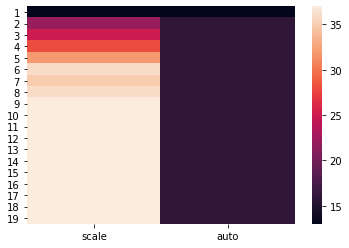

In [184]:
ax = sns.heatmap(right_guess_df)

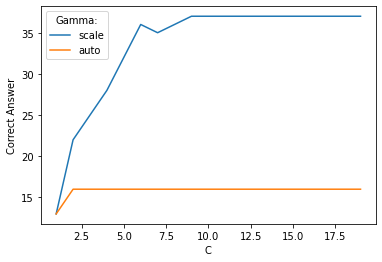

In [185]:
fig, ax = plt.subplots()
ax.plot(c_vals, right_guess_df['scale'].values, label='scale')
ax.plot(c_vals, right_guess_df['auto'].values, label='auto')
plt.xlabel('C')
plt.ylabel('Correct Answer')
plt.legend(title='Gamma:')
plt.show()

In [186]:
max = np.argwhere(right_guess == top["scale"])
max

array([[ 8,  0],
       [ 9,  0],
       [10,  0],
       [11,  0],
       [12,  0],
       [13,  0],
       [14,  0],
       [15,  0],
       [16,  0],
       [17,  0],
       [18,  0]], dtype=int64)

In [187]:
from sklearn.model_selection import GridSearchCV

In [188]:
parameters = {'C': [5,6,7,8,9,10,11,12,13,14,15], 'gamma': ['scale','auto', 0.004, 0.005]}
clf = svm.SVC()
grid_clf = GridSearchCV(clf, parameters)
grid_clf.fit(x_train,y_train.values.ravel())

GridSearchCV(estimator=SVC(),
             param_grid={'C': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                         'gamma': ['scale', 'auto', 0.004, 0.005]})

In [189]:
print(grid_clf.best_params_)

{'C': 12, 'gamma': 'scale'}


In [190]:
grid_clf.best_params_['C']

12

In [191]:
grid_clf.best_params_['gamma']

'scale'

## Testing Phase

In [192]:
#find number of images in file
list = os.listdir(TEST_FOLDER) # dir is your directory path
number_files = len(list)
number_files

65

### Discrete Wavelet Transform

In [193]:
test_dwt= []

In [194]:
#Wavelet Compression
n=2
w = 'haar'

#features array for SVM
x1 = []

for iteration in range(number_files):
    i = iteration+1
    img = Image.open(f'{TEST_FOLDER}/{str(i)}.jpg')
    coeffs = pywt.wavedec2(img, wavelet = w, level = n) 
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs) #arrange coeffs into single array
    
    features = coeff_arr[coeff_slices[0]]
    plt.imsave(f'{TEST_DWT_WITH_DCT_FOLDER}/{str(i)}.jpg', features)

    x1.append(features)    

### Discrete Cosine Transform

In [195]:
test_dct_coeffs =[]

In [196]:
for i in range(number_files):
    img = imread(f'{TEST_DWT_WITH_DCT_FOLDER}/{str(i+1)}.jpg')
    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(grayimg)
    coeff = dctn(equ , norm ='ortho')
    test_dct_coeffs.append(coeff)

In [197]:
coeffs_min = len(test_dct_coeffs[0])*len(test_dct_coeffs[0][0])
ind_coeffs_min = 0
for i in range(len(test_dct_coeffs)):
    if(len(test_dct_coeffs[i])*len(test_dct_coeffs[i][0])<coeffs_min):
        coeffs_min = len(test_dct_coeffs[i])*len(test_dct_coeffs[i][0])
        ind_coeffs_min = i
coeffs_min

638

In [198]:
test_new_coeffs = []
for i in range(number_files):
    whole = []
    for j in range(20):
        row = []
        for k in range(20):
            row.append(test_dct_coeffs[i][j][k])
        whole.append(row)
    test_new_coeffs.append(whole)

In [199]:
test_flat_coeff = []
for n in range(number_files):
    height = len(test_new_coeffs[n])
    width = len(test_new_coeffs[n][0])
    row = []
    for k in range(width+height-1):
        for j in range(k+1):
            i = k-j
            if i<height and j<width:
                if len(row) < coeffs_picked:
                    row.append(test_new_coeffs[n][i][j])
    test_flat_coeff.append(row)

In [200]:
test_new_coeffs_pd = pd.DataFrame(test_flat_coeff)
test_new_coeffs_pd.to_csv('test_dct_coeffs_flat_try2.csv')

In [201]:
test_norm_dct_coeffs = []
for i in range(number_files):
    min_data = test_new_coeffs_pd.iloc[i].min()
    max_data = test_new_coeffs_pd.iloc[i].max()
    row = []
    for j in range(400):
        temp = (test_new_coeffs_pd.iloc[i][j]-min_data)/(max_data-min_data)*100
        row.append(temp)
    test_norm_dct_coeffs.append(row)

### SVM

Test data

In [202]:
x_test = pd.DataFrame(test_norm_dct_coeffs)
y_test = pd.read_csv(TEST_CSV, header=None)

In [203]:
x_test

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,100.0,22.793104,26.617562,0.000000,44.914307,25.413038,21.130464,28.842819,33.509923,19.025787,...,26.881356,26.382355,26.703641,26.776264,26.740786,26.550856,26.384618,26.809822,26.738781,26.690088
1,100.0,6.707161,6.878122,0.000000,14.341054,13.959826,18.788454,20.555451,11.077741,18.199330,...,17.659603,15.051207,17.278529,16.654143,16.895929,17.549980,16.778791,17.077068,17.264003,16.545601
2,100.0,10.742451,0.000000,0.273522,6.769013,19.558107,22.787604,15.669305,4.064077,21.158162,...,16.894048,16.229359,15.612532,16.537767,15.952927,16.355578,17.064708,16.843948,16.517870,15.794924
3,100.0,23.299964,43.542047,0.000000,16.964979,18.743874,14.476177,19.872355,11.310464,20.621847,...,15.513484,15.621557,15.787059,15.683763,15.498843,15.807592,15.835201,15.711174,15.657403,15.961867
4,100.0,16.160736,32.525167,0.000000,20.975016,24.122445,22.522451,28.327499,17.633114,27.923415,...,20.397345,19.739272,19.493231,19.488287,20.000997,19.897170,19.671768,19.828769,19.916128,19.994600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,100.0,33.970085,30.939877,10.155103,23.131745,0.000000,27.786981,23.608250,28.998549,25.763596,...,24.752872,25.465232,24.866144,25.221992,25.245513,25.179234,25.566986,25.440189,25.455756,25.392937
61,100.0,6.215584,18.123175,6.632226,3.566525,4.375256,23.883967,2.668843,15.768198,6.357460,...,10.351894,10.873635,10.255548,10.984270,10.663042,10.469990,10.662641,11.228864,10.654223,10.541369
62,100.0,16.373282,20.101491,3.438291,17.240117,26.589430,12.806009,17.617578,0.000000,11.490358,...,17.595399,16.886954,15.889900,16.615916,16.622044,16.192001,16.589548,16.496079,17.071150,16.889284
63,100.0,30.705510,21.379170,0.000000,37.208099,16.138414,23.937470,28.600827,35.788271,24.597474,...,27.298662,27.069132,27.065759,27.293998,27.334072,27.711603,27.326704,27.302536,27.489717,27.194685


In [204]:
x[145:155]

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
145,100.0,2.839064,8.979910,12.643100,15.506023,35.704360,19.957527,17.044140,0.000000,22.014498,...,17.387598,17.222682,17.695091,17.584225,17.463219,17.285331,17.485193,17.502951,17.564833,17.379054
146,100.0,11.751943,13.061464,17.900955,22.297651,29.283865,21.314352,21.310521,0.000000,25.362510,...,23.022680,22.592852,21.957262,22.931154,22.545408,22.269593,22.496014,22.937312,22.325821,22.722616
147,100.0,15.111891,14.889093,18.399707,20.241301,30.757284,23.820302,24.584748,0.000000,28.402376,...,22.245943,22.941030,22.814203,22.747786,22.910838,23.183619,22.630381,22.692750,22.364468,22.546833
148,100.0,20.344372,0.000000,8.711360,22.451695,11.825578,18.743440,13.924532,5.066867,11.923232,...,18.423142,18.496963,18.424471,18.559203,18.485883,18.472006,18.725190,18.961124,18.720676,18.452116
149,100.0,15.251680,0.000000,15.131060,18.943494,17.095919,19.684693,19.082323,5.971842,15.212285,...,21.165048,21.100055,21.748302,21.087612,21.407718,21.314287,21.211893,21.533417,21.225162,21.249886
150,100.0,6.933120,0.000000,12.980984,12.721628,28.758131,21.920505,18.332010,3.502881,16.167711,...,19.722791,19.989147,19.904531,20.019066,19.548472,20.213802,19.936891,20.276375,20.101541,19.734305
151,100.0,14.778796,0.000000,16.977451,17.463510,25.618408,16.108735,19.915168,10.728131,18.139988,...,22.819600,23.327050,22.975138,22.801114,23.664880,23.597910,23.467154,22.921206,22.937624,22.941531
152,100.0,8.131917,12.094150,3.427229,7.038267,13.114423,14.427390,17.285429,0.000000,27.163322,...,12.824640,13.243045,12.918025,13.619008,13.057508,13.155893,13.222655,13.261825,13.168120,13.337837
153,100.0,14.584594,7.502047,8.699067,14.672491,3.889807,17.826012,18.226093,2.409557,20.625375,...,15.469625,15.587977,16.035808,15.460102,15.536041,15.593702,15.398385,15.507408,15.609303,15.433767
154,100.0,16.477177,18.384610,8.804688,13.009624,18.436133,21.456375,19.394393,0.000000,31.757138,...,17.162814,17.949699,17.508036,17.731855,17.743161,17.495631,17.396430,17.881276,17.629853,17.782835


In [211]:
final_classifier = svm.SVC(C =3)
final_classifier.fit(x_train,y_train.values.ravel())

SVC(C=3)

In [212]:
final_result = final_classifier.predict(x_test)
final_result

array([11, 14,  6,  2,  3, 11, 14,  6,  7, 16,  2, 10,  7, 16, 10, 12, 11,
       10,  2,  6,  8,  6,  3,  2,  5,  1,  7, 11,  3, 18, 13,  7, 10, 11,
       11, 11, 11, 11,  7,  6, 10, 11, 13,  7,  6,  3,  6, 11, 11, 11,  3,
        2,  6, 11, 16, 11, 16, 11, 11, 11,  8, 17,  3, 11,  7],
      dtype=int64)

In [213]:
final_result_df = pd.DataFrame(final_result)
final_result_df.to_csv('dct_final_pred.csv')

In [214]:
final_cnt = 0
for i in range(len(y_test)):
    if(final_result[i]==y_test[0].values[i]):
        final_cnt = final_cnt+1
final_acc = final_cnt/len(y_test)
final_acc*100

13.846153846153847

In [209]:
final_cnt

9

In [210]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [141]:
accuracy_score(y_test, final_result)

0.1076923076923077

In [128]:
precision_score(y_test, final_result, average=None)

C:\Users\asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.08333333, 0.        , 0.07692308, 0.16666667, 0.08333333,
       0.2       , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [60]:
final_prediction = pd.DataFrame(final_result)
final_prediction.to_csv('out.csv')